In [1]:
import numpy as np
import pandas as pd
import random

In [2]:
from subprocess import check_output
print(check_output(["ls", "/Users/micotai/Documents/kaggle"]).decode("utf8"))

kaggle_week1.ipynb
sample_submission.csv
test_ver2.csv
train_ver2.csv



### 資料大小處理
資料有1300多萬筆，為使運算時間不過長，作者取1000筆探勘使用。

In [3]:
N_ROWS = 1000
filename = "/Users/micotai/Documents/kaggle/train_ver2.csv"

n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
#n = 13647309 number of records in train_ver2.csv
print(n)
skip = sorted(random.sample(range(1,n+1),n-N_ROWS)) #the 0-indexed header will not be included in the skip list

13647309


In [4]:
df = pd.read_csv(filename, skiprows=skip)
print(df.shape)

(1000, 48)


### 欄位格式調整
將'fecha_dato'(資料時間)、'fecha_alta'(最早往來日期)，功用、用法類似之前的pandas.to_numeric

In [5]:
df['fecha_dato'] = pd.to_datetime(df['fecha_dato'])
df['fecha_alta'] = pd.to_datetime(df['fecha_alta'])

### 敘述性統計
平均數、標準差、最小值、中位數、xx分位數、最大值。

In [6]:
df_dummiesed = pd.get_dummies(df) #將資料變數轉為虛擬變數
#df_dummiesed = df_dummiesed.sort_values("fecha_dato",ascending=True) #我自己增加的，為了要讓抽樣後的資料依資料年月排序
df_dummiesed = df_dummiesed.drop_duplicates(subset="ncodpers",keep="last") #刪除重複資料
df_dummiesed["fecha_alta"] = pd.to_numeric(df_dummiesed["fecha_alta"]) #轉為數值變數
df_dummiesed["fecha_dato"] = pd.to_numeric(df_dummiesed["fecha_dato"]) #轉為數值變數
#df_dummiesed = df_dummiesed.drop("conyuemp",axis=1).fillna(df_dummiesed.mean()) #處理空值(全部補平均值)，但其實不能這樣做
df_dummiesed = df_dummiesed.drop("conyuemp",axis=1).dropna()#刪除"conyuemp"員工配偶註記欄位，並刪除有任一空值的資料列
print(df_dummiesed.describe([.1, .2, .3, .4, .5, .6, .7, .8, .9]))

         fecha_dato      ncodpers    fecha_alta   ind_nuevo  indrel  \
count  8.140000e+02  8.140000e+02  8.140000e+02  814.000000   814.0   
mean   1.445136e+18  8.007125e+05  1.222592e+18    0.017199     1.0   
std    1.254266e+16  4.143700e+05  1.723508e+17    0.130092     0.0   
min    1.422403e+18  1.685400e+04  8.053344e+17    0.000000     1.0   
10%    1.425807e+18  1.951540e+05  9.755683e+17    0.000000     1.0   
20%    1.432771e+18  3.734134e+05  1.044161e+18    0.000000     1.0   
30%    1.438042e+18  5.147300e+05  1.113463e+18    0.000000     1.0   
40%    1.443398e+18  6.918894e+05  1.184388e+18    0.000000     1.0   
50%    1.445990e+18  8.988025e+05  1.295309e+18    0.000000     1.0   
60%    1.448669e+18  9.846364e+05  1.322438e+18    0.000000     1.0   
70%    1.453939e+18  1.102000e+06  1.353370e+18    0.000000     1.0   
80%    1.459123e+18  1.220277e+06  1.384819e+18    0.000000     1.0   
90%    1.461802e+18  1.319193e+06  1.412191e+18    0.000000     1.0   
max   

### 用KMeans進行客戶分群
silhouette輪廓係數: 一種估算分群開不開的指標<p>
(b - a) / max(a, b)<p>
a: 每個樣本點的組內距離平均；b: 每個樣本點的組間距離(非樣本點的組中，跟樣本點最近的組)平均

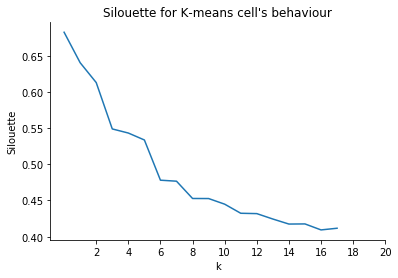

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

s = []
for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_dummiesed)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    s.append(silhouette_score(df_dummiesed, labels, metric='euclidean'))

plt.plot(s)
plt.xticks(np.linspace(2, 20, 10)) #我額外增加的，讓X軸座標能固定下來，方便觀察
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
sns.despine() #讓圖不要有上面和右邊的框線
plt.show()

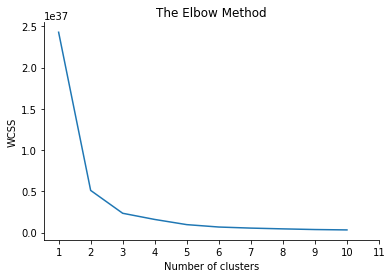

In [8]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_dummiesed)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xticks(np.linspace(1, 11, 11))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
sns.despine()
plt.show()

#### 分群結果的各群個數

[ 1  1  1  5  5  5  7  7  7  7  8  8  8  8  8  8  7  8  8  8  9  9  9  9  9
  3  6  6  2  2  2  2 10  2  2  0  4  0  0  0  0  0  0  0  0  4  4  4  4  4
  4  0  0  2  2  2  6  9  6  3  3  9  0  0  9  9  9  8  8  8  8  8  8  8  8
  7  7  5  5  5  1  1  4  4  4  4  4  4 10  2  0  3  6  3  9  9  8  8  8  8
  7  7  7  7  5  5  5  5  1  8  1  1  4  4  0  4  0 10  2  6  9  9  6  6  9
  9  0  0  0  2  9  9  8  8  8  7  7  7  7  7  7  7  5  5  1  1  1  1  1  1
  1  1  1  1  1  1  8  5  5  5  5  5  7  7  7  7  8  8  8  9  9  0  3  3  9
  9  2 10 10  0  0  0  0  4  4  1  1  1  1  1  5  5  5  5  1  5  7  7  7  7
  7  7  7  8  8  8  8  9  9  9  6  6  6  6  6  6  2  2 10 10  0  0  4  2  2
  4  0  5  5  5  2  2  2  5 10  9  3  6  3  3  0  9  0  0  0  0  0  9  8  1
  1  1  1  8  8  8  5  5  1  1  1  1  7  7  7  7  7  8  8  7  7  8 10  5  5
  5 10 10  5  5  5  5  5  5  4  4  4  4  0 10  2  2  2  2  2  7  8  8  7  1
  1  1  1  1  1  8  8  8  8  6  9  9  3  3  3  9  9  9  9  9  9  4  4  4  4
  0  0  5  5

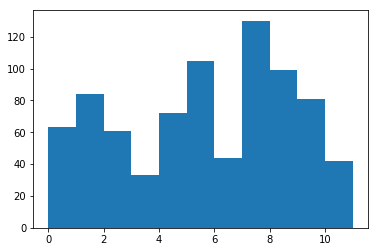

In [9]:
N_CLUSTERS = 11 #labels為群0-群10
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(df_dummiesed)

print(kmeans.labels_)
plt.hist(kmeans.labels_,bins=[0,1, 2, 3, 4,5,6,7,8,9,10,11])
plt.show()

### 計算客戶間的cosine相似性

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(df_dummiesed,dense_output=False)
df_sim = pd.DataFrame(sim,columns=df_dummiesed['ncodpers'],index=df_dummiesed['ncodpers'])

print(df_sim)

ncodpers   1112371   1094635   1094223   935687    940172    960142   \
ncodpers                                                               
1112371   1.000000  0.999999  0.999999  0.999880  0.999889  0.999905   
1094635   0.999999  1.000000  1.000000  0.999898  0.999906  0.999921   
1094223   0.999999  1.000000  1.000000  0.999900  0.999907  0.999922   
935687    0.999880  0.999898  0.999900  1.000000  1.000000  0.999999   
940172    0.999889  0.999906  0.999907  1.000000  1.000000  0.999999   
960142    0.999905  0.999921  0.999922  0.999999  0.999999  1.000000   
1303569   0.999804  0.999779  0.999777  0.999378  0.999397  0.999435   
1282400   0.999829  0.999805  0.999804  0.999423  0.999441  0.999478   
1370038   0.999740  0.999711  0.999709  0.999267  0.999288  0.999329   
1373659   0.999729  0.999700  0.999698  0.999249  0.999271  0.999312   
1170172   0.999967  0.999956  0.999956  0.999722  0.999735  0.999760   
1167695   0.999969  0.999959  0.999958  0.999727  0.999740  0.99

### 用持有產品的註記欄位來分群
####  挑選特定欄位
取出產品持有狀態註記的所有欄位
<a href="https://www.ibm.com/developerworks/cn/opensource/os-cn-pythonre/index.html">re module參考資料</a>

In [11]:
import re 

df_p = df.drop_duplicates(subset="ncodpers",keep="last")
pattern = re.compile("ind_.*_ult1")
prod_cols = [ x for x in df.columns if re.match(pattern,x) ]
prod_cols.append("ncodpers")
prod_cols.append("fecha_datox")#加上客戶代碼、資料年月欄位
print(prod_cols)

df_p = df.loc[:,prod_cols]
df_p = df_p.fillna(0)

['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1', 'ncodpers', 'fecha_datox']


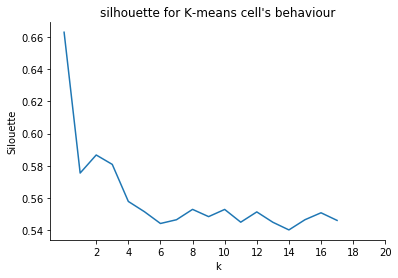

In [12]:
p = []
for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_p)

    labels_p = kmeans.labels_
    centroids = kmeans.cluster_centers_

    p.append(silhouette_score(df_p, labels_p, metric='euclidean'))

plt.plot(p)
plt.xticks(np.linspace(2, 20, 10)) #我額外增加的，讓X軸座標能固定下來，方便觀察
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("silhouette for K-means cell's behaviour")
sns.despine() #讓圖不要有上面和右邊的框線
plt.show()

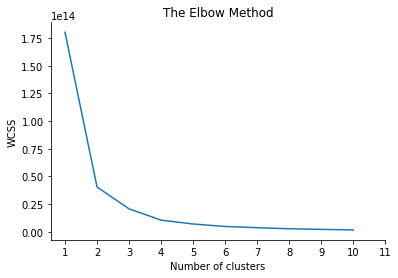

In [13]:
from sklearn.cluster import KMeans
p2 = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_p)
    p2.append(kmeans.inertia_)
plt.plot(range(1, 11), p2)
plt.xticks(np.linspace(1, 11, 11))
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
sns.despine()
plt.show()

[0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 2 0 2 2 2 2 2 2 2 1 1 3 1 3 1 1 1 1 1 1 4 4
 4 4 4 0 4 4 3 3 3 3 3 3 3 3 3 3 4 4 4 4 3 3 3 4 3 3 3 4 4 4 4 1 1 1 1 1 1
 3 3 3 3 3 1 1 2 2 2 2 2 2 0 2 2 2 2 0 0 0 0 0 0 0 4 3 3 4 4 4 3 4 4 1 1 1
 1 1 1 1 3 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 3 4 3 3 3 4 4 4 1 1 1 1
 1 1 3 3 3 3 3 3 3 3 2 2 2 2 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 2 2 2 0 2 2 2 1 3 3 1 1 1 1 4 4 4 4 3 3 3 3 3 4 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 3 3 1 1 1 1 1 1 1 4
 4 4 4 4 4 3 3 3 4 4 3 3 3 0 0 0 4 4 4 4 4 1 1 1 1 1 1 1 3 3 3 3 3 3 3 1 3
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0
 4 4 0 0 0 0 0 0 0 3 3 4 4 3 3 3 3 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 0 0 2 2 2 0 1 1 1 1 1 1 3 3 3 3 3 1 1 1 3 4 4 3 3 3 0 0 0 4 4 4 4
 1 1 1 1 1 1 3 3 3 1 1 1 2 2 2 2 4 4 4 4 4 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 

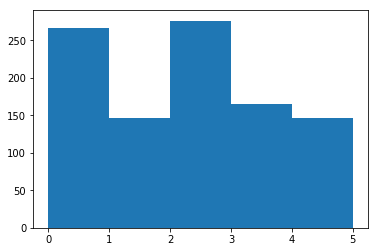

In [14]:
N_CLUSTERS = 5 #labels為群0-群4
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(df_p)

print(kmeans.labels_)
plt.hist(kmeans.labels_,bins=[0,1, 2, 3, 4,5])
plt.show()

### 總結
1. 補值的方法也不能全部補平均值，像是類別變數轉為虛擬變數補進平均值沒有意義；<p>
2. 分群後可以將同一群的再進行資料探索，可能可找到顯著差異，再依序建多個模型。<p>